In [1]:
from mitoolspro.regressions import linear_models
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Robust Linear Models from Statsmodels

https://www.statsmodels.org/stable/examples/notebooks/generated/robust_models_0.html

## Estimation

Load data:

In [2]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)
data = pd.concat([data.exog, data.endog.to_frame()], ignore_index=False, axis=1)
data

,const,AIRFLOW,WATERTEMP,ACIDCONC,STACKLOSS
0,1.0,80.0,27.0,89.0,42.0
1,1.0,80.0,27.0,88.0,37.0
2,1.0,75.0,25.0,90.0,37.0
3,1.0,62.0,24.0,87.0,28.0
4,1.0,62.0,22.0,87.0,18.0
5,1.0,62.0,23.0,87.0,18.0
6,1.0,62.0,24.0,93.0,19.0
7,1.0,62.0,24.0,93.0,20.0
8,1.0,58.0,23.0,87.0,15.0
9,1.0,58.0,18.0,80.0,14.0


Huber’s T norm with the (default) median absolute deviation scaling

In [3]:
huber_t = linear_models.RLMModel(data=data, dependent_variable="STACKLOSS", independent_variables=["AIRFLOW", "WATERTEMP", "ACIDCONC"], M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(
    hub_results.summary(
        yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

const       -41.026498
ACIDCONC     -0.127847
AIRFLOW       0.829384
WATERTEMP     0.926066
dtype: float64
const        9.791899
ACIDCONC     0.128650
AIRFLOW      0.111005
WATERTEMP    0.302930
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 19 Mar 2025                                         
Time:                        21:32:17                                         
No. Iterations:                    19                                         


Huber’s T norm with ‘H2’ covariance matrix

In [4]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

const       -41.026498
ACIDCONC     -0.127847
AIRFLOW       0.829384
WATERTEMP     0.926066
dtype: float64
const        9.089504
ACIDCONC     0.117963
AIRFLOW      0.119460
WATERTEMP    0.322355
dtype: float64


Andrew’s Wave norm with Huber’s Proposal 2 scaling and ‘H3’ covariance matrix

In [5]:
andrew_mod = linear_models.RLMModel(data=data, dependent_variable="STACKLOSS", independent_variables=["AIRFLOW", "WATERTEMP", "ACIDCONC"], M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print("Parameters: ", andrew_results.params)

Parameters:  const       -40.881796
ACIDCONC     -0.133609
AIRFLOW       0.792761
WATERTEMP     1.048576
dtype: float64


See 'help(sm.RLM.fit)' for more options and module 'sm.robust.scale' for scale options

## Comparing OLS an RLM

Artificial data with outliers:

In [6]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects.



In [7]:
res = linear_models.OLSModel.from_arrays(y=y2, X=X).fit()
print(res.params)
print(res.bse)
print(res.predict())

x1    5.005916
x2    0.524200
x3   -0.013273
dtype: float64
x1    0.454068
x2    0.070102
x3    0.006203
dtype: float64
[ 4.67409669  4.94001911  5.20151911  5.4585967   5.71125188  5.95948464
  6.20329498  6.44268292  6.67764843  6.90819154  7.13431223  7.3560105
  7.57328637  7.78613981  7.99457085  8.19857946  8.39816567  8.59332946
  8.78407083  8.9703898   9.15228634  9.32976048  9.50281219  9.6714415
  9.83564839  9.99543286 10.15079493 10.30173457 10.44825181 10.59034663
 10.72801903 10.86126902 10.9900966  11.11450176 11.23448451 11.35004484
 11.46118276 11.56789826 11.67019135 11.76806203 11.86151029 11.95053614
 12.03513957 12.11532059 12.1910792  12.26241539 12.32932916 12.39182053
 12.44988947 12.50353601]


Estimate RLM:

In [8]:
resrlm = linear_models.RLMModel.from_arrays(y=y2, X=X).fit()
print(resrlm.params)
print(resrlm.bse)

x1    4.950309
x2    0.506536
x3   -0.002169
dtype: float64
x1    0.124089
x2    0.019158
x3    0.001695
dtype: float64


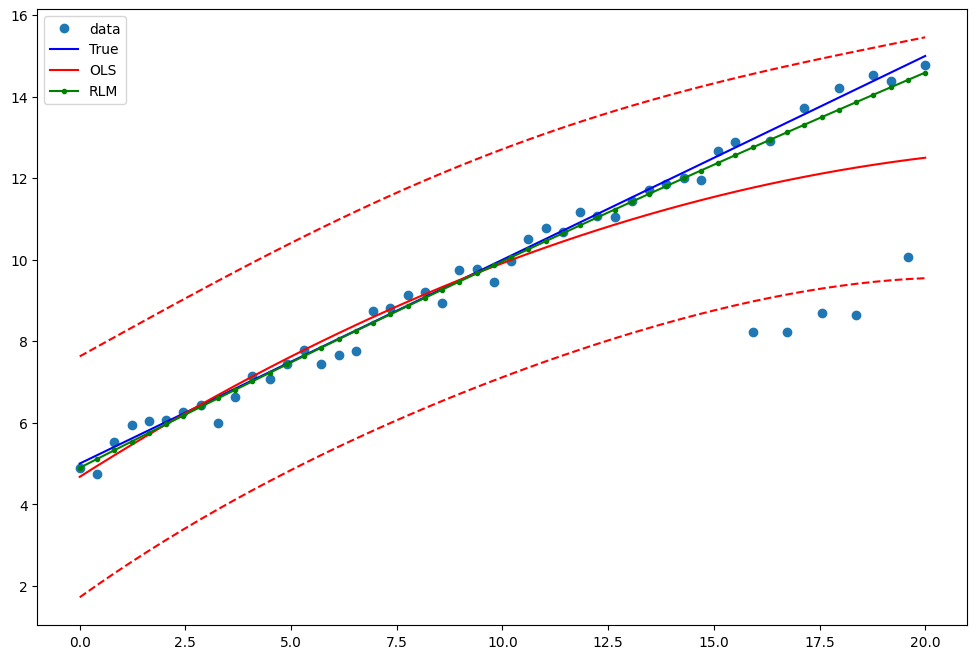

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [10]:
X2 = X[:, [0, 1]]
res2 = linear_models.OLSModel.from_arrays(y=y2, X=X2).fit()
print(res2.params)
print(res2.bse)

x1    5.540890
x2    0.391472
dtype: float64
x1    0.392913
x2    0.033855
dtype: float64


Estimate RLM:

In [11]:
resrlm2 = linear_models.RLMModel.from_arrays(y=y2, X=X2).fit()
print(resrlm2.params)
print(resrlm2.bse)


x1    5.025768
x2    0.487313
dtype: float64
x1    0.093586
x2    0.008064
dtype: float64


Draw a plot to compare OLS estimates to the robust estimates:

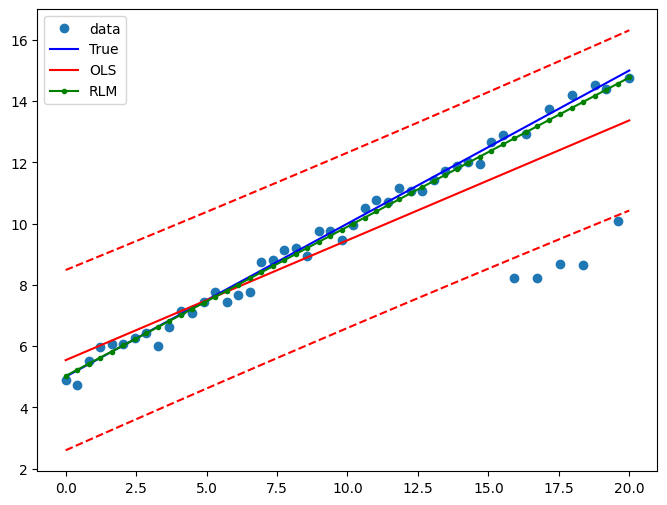

In [12]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")

***